# The loss landscape: Normalization & Residual Networks

I kind of lied when I said I want

$$\arg\min_\Theta L(\Theta)$$

for

$$L(\Theta) = \frac{1}{|\mathscr{D}|}\sum_{(x,y)\in\mathscr{D}} \mathscr{l}(\phi_\Theta(x), y).$$

## Stepping back

Recall from the first lecture that we optimize $L(\Theta)$ but only as a surrogate for

$$L^*(\Theta) = \mathbb{E}_{(x,y)\sim p_{X,Y}} \mathscr{l}(\phi_\Theta(x), y).$$

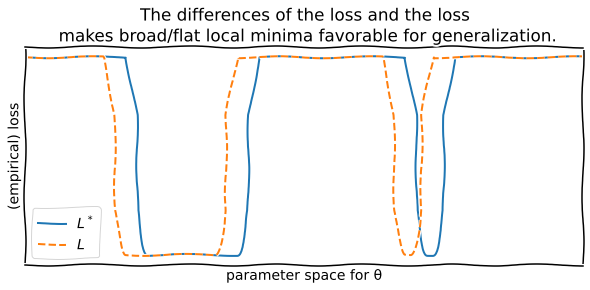

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
plt.xkcd()

θs = np.linspace(0, 1, 1000)

def l(θs):
    loss = np.ones_like(θs)
    loss[(.2 < θs) & (θs < .4)] = 0
    loss[(.7 < θs) & (θs < .75)] = 0

    loss = np.convolve(loss, np.ones(40)/40, mode='same')

    loss[(θs < .1) | (.8 < θs)] = 1

    loss[loss <  .5] = loss[loss  < .5]**2
    loss[loss >= .5] = loss[loss >= .5]**.5
    return loss

L_star = l(θs)
L = l(θs + .04)

plt.title("The differences of the loss and the loss\n makes broad/flat local minima favorable for generalization.")
plt.plot(θs, L_star, "-", label=r"$L^*$")
plt.plot(θs, L, "--", label=r"$L$")

plt.xlabel("parameter space for θ")
plt.ylabel("(empirical) loss")

plt.xticks([])
plt.yticks([])
plt.xlim(0, 1)

plt.legend()
plt.gcf().set_size_inches(10, 4)
plt.show()

## SGD is not only cheap, it regularizes

* Remember that the SGD theorem tells us that in the convex case we converge into a ball around the minimum.
* If we assume that local minima look convex-ish, then SGD will "prefere" broad/flat minima.
    + If the SGD convergence ball is smaller than the local minimum it can jump out and "run away" to a different minimum. This does not happen if the ball is firmly within a minimum that is broader than the convergence ball.
* We want that the training's output (the function) is robust to the training dataset.
    + We want any single additional/removed sample to have a small influence on the empirical loss.
    + I.e., it will have a small influence on whether a parameter choice stays in a flat minimum, but a potentially large one on whether it stays in a sharp.

## Side effects of flat minima ([Source.](https://arxiv.org/pdf/2105.13462.pdf))

### Inputs can inherit stability from parameters
If we look at a neural network $\tilde f_{\tilde\Theta}(x)$ from which we notationally extract the first linear mapping to write

$$f_{\Theta}(Wx) = \tilde f_{\tilde\Theta}(x).$$

This gives us

$$\nabla_W f_{\Theta}(Wx) = \frac{\partial f_\Theta(Wx)}{\partial Wx} x^T$$

and

$$\nabla_x f_\Theta(Wx) = \frac{\partial f_\Theta(Wx)}{\partial Wx} W.$$

This allows us to compute the bound

$$\|\nabla_x f_\Theta(Wx)\|_2 \le \frac{\|W\|_2}{\|x\|_2} \|\nabla_W f_{\Theta}(Wx)\|_2.$$

If we assume that $\|x\|$ is not too small and $\|W\|$ is not to large then we have a nice bound. These assumtions are not unreasonable.
1. We usually normalize and preprocess the inputs of our network. This can be used to have a lower bound on $\|x\|$.
2. We often use normalization techniques that essentially bound $\|W\|$. E.g., weight decay and normalizations. More on that later.

**To summarize:** If a net/loss is stable/robust in its parameters it is reasonable to expect it is stable/robust in its inputs.

### A formal connection between flatness/robustness in parameter and input space

For a regression problem we can define

$$L(W, \Theta) = \frac{1}{n}\sum_i \frac{1}{2} (f_\Theta(Wx_i) - y)^2$$

We define $(W^*, \Theta^*) = \arg\min L(W, \Theta)$ and assume

1. $f_{\Theta^*}(W^*x_i)=y_i \ \forall i=1,\dots, n$ and
2. $L(W^*, \Theta^*) = 0$.

For the moment we will use the popular definiton

$$\mbox{flatness}(W^*) = \mbox{Tr}\left[H_WL(W^*, \Theta^*)\right],$$

i.e., we define flatness as the trace of the Hessian.

We can compute

$$\nabla_W L(W^*, \Theta^*) = \frac{1}{n}\sum_i \nabla_Wf_\Theta(W^*x_i) [f_\Theta(W^*x_i) - y_i]^T$$

and

$$H_W L(W^*, \Theta^*)
= \frac{1}{n}\sum_i H_Wf_\Theta(W^*x_i) [f_\Theta(W^*x_i) - y]^T + \nabla_W f_\Theta(W^*x_i) \otimes \nabla_W f_\Theta(W^*x_i)$$
$$H_W L(W^*, \Theta^*) = \frac{1}{n}\sum_i \nabla_W f_\Theta(W^*x_i) \otimes \nabla_W f_\Theta(W^*x_i).$$

This means we can equivalently define

$$\mbox{flatness}(W^*) = \frac{1}{n}\sum_i \|\nabla_W f_\Theta(W^*x_i)\|_2^2.$$

A way of thinking about this is that if the loss is flat around $W^*$ (i.e., small flatness), then every sample is "happy" with $W^*$, i.e., the gradient based on the sample does not want to run too far away from $W^*$.
Note, if you are interested read about the [Fisher information](https://en.wikipedia.org/wiki/Fisher_information).

We can now use the earlier bound to connect the flatness in the parameter space to flatness/robustness in the input space

$$\frac{1}{n}\sum_i \|\nabla_x f_{\Theta^*}(W^*x_i)\|_2^2 \le \frac{\|W^*\|_2^2}{\min_i\|x_i\|_2^2} \frac{1}{n}\sum_i  \|\nabla_W f_{\Theta^*}(W^*x_i)\|_2^2 \le \frac{\|W^*\|_2^2}{\min_i\|x_i\|_2^2} \mbox{flatness}(W^*).$$

## A high-level ansatz/hunch to make the loss smoother (& create flatter minimia)
Consider a gradient step via backpropagation, i.e., via the chain rule.
+ We update the last layer based on the loss.
+ We update the second to last layer based on the loss and the last layer.
+ The first layer changes based on the loss and all other layers.
+ All layer above the first layer did not change based on how the first layer changes.
+ If the first layer changes all other layers are somewhat suboptimal.
+ This can lead to suboptimal and slow training processes.

Can we change something to make the parameters of the later layers less dependent on the ones of the earlier layers? E.g., reduce the diversity of their output; or make some aspect of their output irrelevant. All while retaining expressivity?

## Normalization

The different **normalization layers** mainly differ in how they chose the slices they normalize over.

```{figure} images/normalizations.png
---
height: 200px
---
Normalization methods. Each subplot shows a feature map tensor, with N as the batch axis, C as the channel axis, and (H, W) as the spatial axes. The pixels in blue are normalized by the same mean and variance, computed by aggregating the values of these pixels. [Source.](https://arxiv.org/pdf/1803.08494.pdf)
```

Let $x$ be a slice (not sample) of the batch $X$ according to some of the colored parts above. A normalization layer maps

$$\overline X = \gamma \tilde X + \beta$$

with $\gamma, \beta \in \mathbb{R}^C$ multiplying/adding channel specific Hadamard-like and

and $\tilde X$ being assembled from slices:

$$\tilde x = \frac{1}{\sigma(x)}(x - \mu(x))$$

$$\mu(x) = \frac{1}{|S(x)|}\sum_{x'\in S(x)} x'$$

$$\sigma(x) = \sqrt{\frac{1}{|S(x)|}\sum_{x'\in S(x)} (x' - \mu(x))^2 + \epsilon}.$$

```{warning}
Batch normalization requires a batch to work. During (potentially single sample) inference one uses "old" $\mu$ and $\sigma$ from the training.
```

* "Random" shifts and scalings per mini batch $\Rightarrow$ encourages robustness of later layers.
    + Note, this is somewhat similar to why [dropout](https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer,) works.
    + Can be thought of as a regularization.
* (Batch) normalization seems to **decrease the Lipschitz constant of the loss function and of its gradients**. ([Source.](https://proceedings.neurips.cc/paper/2018/file/905056c1ac1dad141560467e0a99e1cf-Paper.pdf))
    + I.e., small gradients and small changes of the gradient. Smoother loss means less sharp minima.

## Residual Networks

* Idea: Let all layer/ResBlock-updates not only depend on the loss indirectly via the next layer, but directly, by letting the layer directly feed into the loss.

Instead of using layers of the form

$$x\mapsto \phi(Ax + a)$$

or

$$x\mapsto NP\phi(Ax + a),$$

where $N$ is a normalization layer and $P$ a pooling, Residual Networks ([ResNets](https://arxiv.org/pdf/1512.03385.pdf)) use layers of the form

$$x\mapsto Px + Pf(x)$$

or

$$x\mapsto \phi(Px + Pf(x))$$

where $P$ the identity or some kind of pooling, $\phi$ some activation function, and $f$ some type of small network. For some examples see the following figure.

```{figure} images/resnet_flavors.png
---
height: 300px
---
ResNet blocks flavors. [Source 1.](https://www.doc.ic.ac.uk/~bkainz/teaching/DL/notes/ResNet.pdf) [Source 2.](https://d2l.ai/chapter_convolutional-modern/resnet.html)
```

* Each layer can add a small update and does not need to preserve the *work* of the previous layer.
* A bit like a gradient boosting model where you can train all models in parallel.
* If someone tells you that ResNets work because they solve the problem of *vanishing gradients* ask them about why ResBlocks improve networks where the problem is already solved via normalization layers. [Source.](https://arxiv.org/pdf/1512.03385.pdf)

* Non-ResNets layer:
    - Needs to solve the problem of producing a good input for the next layer.
    - Needs to preserve the parts of its input that might be useful for later layers.
* ResNets layer:
    - Can improve the input for the next layer.
    - It is easy to preserve the useful parts of the layer's input.
    - Each layer can also directly work on the final output.

## Visualization of the loss landscape ([Source.](https://arxiv.org/pdf/1712.09913.pdf))

* It is challanging plot the loss landscape as it extremly high dimensional.
* Approach: Take two random direction in the parameter space and plot along those.
* One needs to carfully scale the directions as the ouput of a ReLU network does not change if one scales the parameters of one layer by a factor of $10$ and divides the next ones by the same factors.

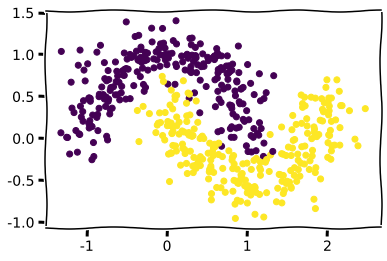

In [2]:
import copy
import torch
import matplotlib
from sklearn.datasets import make_moons

def get_dataset(n_samples=512):
    xs, ys = make_moons(
        n_samples=512,
        shuffle=True,
        noise=0.2,
        random_state=42
    )

    xs = torch.tensor(xs, dtype=torch.float32).view(-1, 2)
    ys = torch.tensor(ys, dtype=torch.float32).view(-1, 1)
    return xs, ys


xs, ys = get_dataset()
xs_valid, ys_valid = get_dataset()

plt.scatter(xs[:,0], xs[:,1], c=ys)
plt.show()

In [3]:
def get_model(depth, width, use_norm=False):
    assert depth >= 2, "Depth must be >= 1"
    assert width >= 1, "Width must be >= 1"

    model = torch.nn.Sequential()

    model.add_module(f"layer_0", torch.nn.Linear(2, width))
    model.add_module(f"relu_0", torch.nn.ReLU())
    if use_norm:
        model.add_module(f"ln_0", torch.nn.LayerNorm(width))

    for i in range(1, depth - 1):
        model.add_module(f"layer_{i}", torch.nn.Linear(width, width))
        model.add_module(f"relu_{i}", torch.nn.ReLU())
        if use_norm:
            model.add_module(f"ln_{i}", torch.nn.LayerNorm(width))

    model.add_module("last_layer", torch.nn.Linear(width, 1))

    return model

In [4]:
def get_train_batch(batch_size=2):
    idxs = torch.randperm(len(xs))[:batch_size]

    xs_batch = xs[idxs]
    ys_batch = ys[idxs]

    return xs_batch, ys_batch

In [5]:
def get_train_and_eval_model(depth, width, use_norm):
    model = get_model(depth, width, use_norm)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.BCEWithLogitsLoss()

    losses = []

    for _ in range(8000):
        xs_batch, ys_batch = get_train_batch()
        ys_hat = model(xs_batch)

        loss = criterion(ys_hat, ys_batch)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    plt.plot(losses)
    plt.show()

    model.eval()
    ys_hat = torch.sigmoid(model(xs_valid)).detach()

    plt.scatter(xs_valid[:,0], xs_valid[:,1], c=ys_hat)
    plt.colorbar()
    plt.show()

    return model

In [6]:
class LossLandscapeVisualizerMLP:
    def __init__(self, mlp, criterion, xs, ys):
        self.mlp = mlp
        self.mlp.eval()

        self.criterion = criterion

        self.xs, self.ys = xs, ys

        self.directions0 = self.get_random_direction(self.mlp)
        self.directions1 = self.get_random_direction(self.mlp)


    def get_weights_of_layers(self, mlp):
        all_children = list(mlp.children())
        linear_layers = [child for child in all_children if torch.nn.Linear == type(child)]
        weights = [layer.weight for layer in linear_layers]

        return weights


    def get_random_direction(self, mlp, normalized=True):
        weights = self.get_weights_of_layers(mlp)
        noises = [torch.randn_like(weight) for weight in weights]
        if normalized:
            noises = [noise / noise.norm(dim=1).view(-1, 1) * weight.norm(dim=1).view(-1, 1)  for noise, weight in zip(noises, weights)]
        return noises


    def get_mlp_with_shifted_weights(self, mlp, shifts):
        mlp_copy = copy.deepcopy(mlp)
        weights = self.get_weights_of_layers(mlp_copy)

        for weight, shift in zip(weights, shifts):
            weight.data += shift

        return mlp_copy


    def get_shifted_model(self, α, β):
        shifts = [α * a + β * b for a, b in zip(self.directions0, self.directions1)]
        mlp_copy = self.get_mlp_with_shifted_weights(self.mlp, shifts)
        return mlp_copy


    @torch.no_grad()
    def loss_for_model(self, mlp):
        mlp.eval()
        ys_hat = mlp(self.xs)
        loss = self.criterion(ys_hat, self.ys).item()
        return loss


    @torch.no_grad()
    def loss_for_shifted_model(self, α, β):
        shifted_mlp = self.get_shifted_model(α, β)
        shifted_mlp.eval()
        ys_hat = shifted_mlp(self.xs)
        loss = self.criterion(ys_hat, self.ys).item()
        return loss


    def plot_loss_landscape(self, max_shift_size=.5, resolution=100):
        αs = np.linspace(-max_shift_size, max_shift_size, resolution)
        βs = np.linspace(-max_shift_size, max_shift_size, resolution)

        losses = []

        for α in αs:
            for β in βs:
                loss = viz.loss_for_shifted_model(α, β)
                losses.append((α, β, loss))

        losses = np.array(losses)

        plt.scatter(losses[:,0], losses[:,1], c=losses[:,2])
        plt.colorbar()
        plt.show()

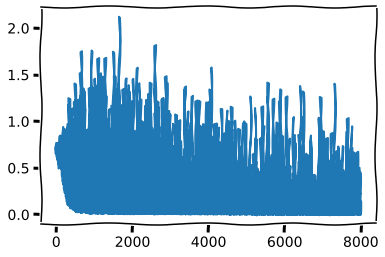

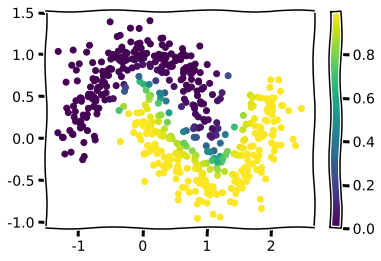

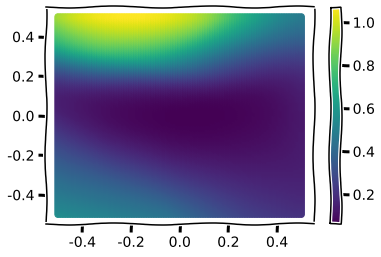

In [7]:
model = get_train_and_eval_model(depth=3, width=16, use_norm=False)
viz = LossLandscapeVisualizerMLP(model, torch.nn.BCEWithLogitsLoss(), *get_dataset())
viz.plot_loss_landscape()

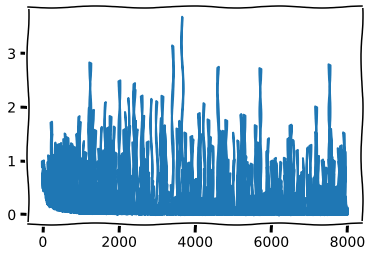

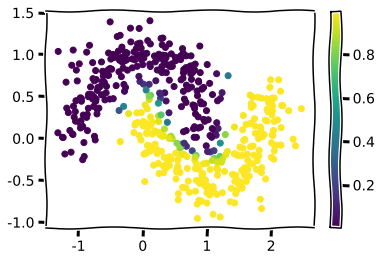

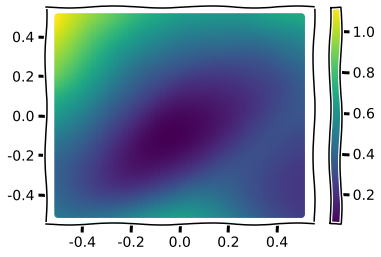

In [8]:
model = get_train_and_eval_model(depth=3, width=16, use_norm=True)
viz = LossLandscapeVisualizerMLP(model, torch.nn.BCEWithLogitsLoss(), *get_dataset())
viz.plot_loss_landscape()

## Exercises
* Implement a ResNet and train it on MNIST compare the training and result to the same net but without the skip connections. Add LayerNomrmalization layers to both variants and compare with those. I.e., compare 4 types of nets.
* Plot random projection of the loss, one for each layer separately.
* Plot the landscape for Residual Networks and compare them to non-residual networks.
* Plot the landscape for networks trained with small and large batch sizes.